

このコンペティションは、「データサイエンスコンペティションに勝つ方法」Coursera コースの最終課題として提供されています。

このコンペティションでは、ロシアの最大手ソフトウェア会社の1つである1C社から提供された、毎日の売上データからなる時系列データセットを使って課題に取り組みます。

## 目的
各商品ごとの来月の販売数（item_cnt_month）を予測することです。<br>
この課題を解くことで、あなたのデータサイエンスのスキルを応用し、高めることができるでしょう。

## 評価
二乗平均誤差(RMSE)で評価されます。真の目標値は[0,20]の範囲にクリップされます。

## データ

- sales_train.csv - トレーニングセットです。2013年1月から2015年10月までの毎日の履歴データです。
- test.csv - テストセットです。これらのショップや商品の2015年11月の売上を予測する必要があります。
- sample_submission.csv - 正しい形式のサンプル提出ファイルです。
- items.csv - アイテム/商品に関する補足情報です。
- item_categories.csv - アイテムのカテゴリに関する補足情報です。
- shops.csv - ショップに関する補足情報です。

- データ構造
    - ID - テストセット内の(ショップ、アイテム)タプルを表すId
    - shop_id - ショップの一意の識別子
    - item_id - 製品の一意の識別子
    - item_category_id - アイテムカテゴリの一意の識別子。
    - item_cnt_day - 販売された製品の数。このメジャーの毎月の量を予測しています。
    - item_price - アイテムの現在の価格
    - date - 日付のフォーマット dd/mm/yyyy
    - date_block_num - 連続した月の番号で、便宜上使用します。2013年1月は0、2013年2月は1、...、2015年10月は33
    - item_name - アイテムの名前
    - shop_name - ショップ名
    - item_category_name - アイテムカテゴリの名前

## import 

In [1]:
# データ操作
import numpy as np
import pandas as pd
# 乱数
import random
# カテゴリー変数のラベルエンコーディング
from sklearn.preprocessing import LabelEncoder
# ファイル管理
import os
import zipfile
# 警告の非表示
import warnings
warnings.filterwarnings('ignore')
# 可視化表示
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# モデルの定義
from sklearn.ensemble import RandomForestClassifier
import torch

In [2]:
# 乱数の設定
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

## zipファイルの解凍

In [3]:
pred_future_dir = './data/competitive-data-science-predict-future-sales/'

# フォルダ''./data/titanic/'が存在しない場合にzipの解凍
if not os.path.exists(pred_future_dir):
    # home-credit-default-risk.zipを解凍
    with zipfile.ZipFile('./data/competitive-data-science-predict-future-sales.zip','r') as file:
        # /home-credit-default-riskディレクトリを作りその中に解凍ファイルを作製
        file.extractall(pred_future_dir)

## データの読み込み

利用可能なすべてのデータファイルをリストアップします。ファイルは全部で9つあります。
訓練用のメインファイル（ターゲットあり）1つ、テスト用のメインファイル（ターゲットなし）1つ、提出例ファイル1つ、各ローンに関する追加情報を含む他の6つのファイルです。

In [4]:
PATH = './data/competitive-data-science-predict-future-sales'
# 利用可能なファイルリスト
print(os.listdir(PATH))

['items.csv', 'item_categories.csv', 'sales_train.csv', 'sample_submission.csv', 'shops.csv', 'submit_lightgbm.csv', 'submit_lightgbm_drop_futer.csv', 'test.csv']


In [5]:
# 訓練データの読み込み
sales_train = pd.read_csv(PATH+'/sales_train.csv')

## functionの定義
reduce_mem_usageは、データのメモリを減らすためにデータ型を変更する関数です。
('reduce_mem_usage' is a functin which reduce memory usage by changing data type.) https://qiita.com/hiroyuki_kageyama/items/02865616811022f79754　を参照ください。

In [6]:
def reduce_mem_usage(df, verbose=True):
    """
    データのメモリを減らすためにデータ型を変更する関数
    （引用元：https://www.kaggle.com/fabiendaniel/elo-world）
    （参考：https://qiita.com/hiroyuki_kageyama/items/02865616811022f79754）
    Param:
        df: DataFrame
        変換したいデータフレーム
        verbose: bool
        削減したメモリの表示
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        # columns毎に処理
        col_type = df[col].dtypes
        if col_type in numerics:
            # numericsのデータ型の範囲内のときに処理を実行. データの最大最小値を元にデータ型を効率的なものに変更
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
# データの読み込みとデータサイズの削減
sales_train = reduce_mem_usage(sales_train)
test = pd.read_csv(PATH+'/test.csv')
test = reduce_mem_usage(test)

sample_sub = pd.read_csv(PATH+'/sample_submission.csv')

items = pd.read_csv(PATH+'/items.csv')
items = reduce_mem_usage(items)
item_categories = pd.read_csv(PATH+'/item_categories.csv')
item_categories = reduce_mem_usage(item_categories)
shops = pd.read_csv(PATH+'/shops.csv')
shops = reduce_mem_usage(shops)

Mem. usage decreased to 50.40 Mb (62.5% reduction)
Mem. usage decreased to  1.43 Mb (70.8% reduction)
Mem. usage decreased to  0.23 Mb (54.2% reduction)
Mem. usage decreased to  0.00 Mb (39.9% reduction)
Mem. usage decreased to  0.00 Mb (38.6% reduction)


## データごとの確認と特徴量の作成（特徴量の作成はpandas_profiling実行後に行っています）

順序で分析しちゃうからLabelEncoderより、one-hotencodingをしたかったけどMemoryErrorになるので微調整してます。（へぼだから解決案が...訓練データとテストデータの数が合わないとか？）

In [8]:
# 訓練データの表示確認
print(sales_train.shape)
sales_train.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1.0
1,03.01.2013,0,25,2552,899.000000,1.0
2,05.01.2013,0,25,2552,899.000000,-1.0
3,06.01.2013,0,25,2554,1709.050049,1.0
4,15.01.2013,0,25,2555,1099.000000,1.0


In [9]:
# テストデータの表示確認
print(test.shape)
test.head()

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


testに存在してtrainにないitem_idを探します。<br>もしあった場合、これらの商品に対しての目的変数（今月の売り上げ）は予測できないので、0 にする必要があります。

この値はtestのitem_idの種類からtestのitem_idの種類とtrainのitem_idの種類の積集合を引いた値になります。
※testのitem_idの種類であり、trainのitem_idの種類である集合とtestのitem_idの種類を引けばtestのitem_idの種類以外のtrainのitem_idの種類がわかります。


In [10]:
# testのitem_idの種類の数とtrainのitem_idの種類の共通部分の要素数を取得 test['item_id']の要素数から引かれるのでsetとして作成
test_item_id_inter = len(set(test['item_id']).intersection(set(sales_train['item_id'])))
test_item_id_len = len(set(test['item_id']))

# testに存在してtrainにないitem_idを出力
print(test_item_id_len - test_item_id_inter)
# testの商品IDの数(重複は除く)
print(test_item_id_len)
# testの総数
print(len(test))

363
5100
214200


In [11]:
# submitfileの表示確認
print(sample_sub.shape)
sample_sub.head()

(214200, 2)


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [12]:
print(items.shape)
items.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


`item_name`はid以上に情報がなさそうなので列を削除

In [13]:
items = items.drop(['item_name'], axis=1)

In [14]:
print(item_categories.shape)
item_categories.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [15]:
item_categorie = item_categories['item_category_name'].unique()
item_categorie

array(['PC - Гарнитуры/Наушники', 'Аксессуары - PS2', 'Аксессуары - PS3',
       'Аксессуары - PS4', 'Аксессуары - PSP', 'Аксессуары - PSVita',
       'Аксессуары - XBOX 360', 'Аксессуары - XBOX ONE', 'Билеты (Цифра)',
       'Доставка товара', 'Игровые консоли - PS2',
       'Игровые консоли - PS3', 'Игровые консоли - PS4',
       'Игровые консоли - PSP', 'Игровые консоли - PSVita',
       'Игровые консоли - XBOX 360', 'Игровые консоли - XBOX ONE',
       'Игровые консоли - Прочие', 'Игры - PS2', 'Игры - PS3',
       'Игры - PS4', 'Игры - PSP', 'Игры - PSVita', 'Игры - XBOX 360',
       'Игры - XBOX ONE', 'Игры - Аксессуары для игр',
       'Игры Android - Цифра', 'Игры MAC - Цифра',
       'Игры PC - Дополнительные издания',
       'Игры PC - Коллекционные издания', 'Игры PC - Стандартные издания',
       'Игры PC - Цифра', 'Карты оплаты (Кино, Музыка, Игры)',
       'Карты оплаты - Live!', 'Карты оплаты - Live! (Цифра)',
       'Карты оплаты - PSN', 'Карты оплаты - Windows (Цифра)',

`item_category_name`は「タイプ-サブタイプ」の構成になっています。<br>
`type`と`subtype`を新しい特徴量として追加します。

In [16]:
# '-'でカテゴリ名を分割
item_categories['split'] = item_categories['item_category_name'].str.split('-')
# typeには-で分割した先頭の値を代入
item_categories['type'] = item_categories['split'].map(lambda x:x[0].strip())
# sub_typeには-で分割した2番目の値を代入、sub-typeには、typeのデータをsub_typeとして代入
item_categories['sub_type'] = item_categories['split'].map(lambda x:x[1].strip() if len(x) > 1 else x[0].strip())
item_categories.head()

,item_category_name,item_category_id,split,type,sub_type
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,Гарнитуры/Наушники
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,PS2
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,PS3
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,PS4
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,PSP


In [17]:
# splitカラムの削除
item_categories.drop('split', axis=1, inplace=True)
# 'item_category_name'カラムの削除
item_categories.drop('item_category_name', axis=1, inplace=True)

In [18]:
item_categories['type'].value_counts()

Книги                                13
Подарки                              12
Игровые консоли                       8
Игры                                  8
Аксессуары                            7
Программы                             6
Музыка                                6
Кино                                  5
Игры PC                               4
Карты оплаты                          4
Служебные                             2
Чистые носители (штучные)             1
Доставка товара                       1
Игры MAC                              1
Чистые носители (шпиль)               1
PC                                    1
Игры Android                          1
Элементы питания                      1
Карты оплаты (Кино, Музыка, Игры)     1
Билеты (Цифра)                        1
Name: type, dtype: int64

In [19]:
item_categories['sub_type'].value_counts()

Цифра                     4
PS4                       3
Blu                       3
XBOX 360                  3
PS3                       3
                         ..
Гаджеты, роботы, спорт    1
Гарнитуры/Наушники        1
1С:Предприятие 8          1
Комиксы, манга            1
PSN                       1
Name: sub_type, Length: 65, dtype: int64

In [20]:
# # typeをone-hot encodingする
# types = pd.DataFrame(item_categories['type'])
# # one-hot encoding
# types = pd.get_dummies(types)

# # shops, city_onehotを横方向に連結
# item_categories = pd.concat([item_categories, types], axis=1)
# # shopsからcity_nameカラムを削除
# item_categories.drop('type', axis=1, inplace=True)
# item_categories.head()

In [21]:
# # sub_typeをone-hot encodingする
# sub_types = pd.DataFrame(item_categories['sub_type'])
# # one-hot encoding
# sub_types = pd.get_dummies(sub_types)

# # shops, city_onehotを横方向に連結
# item_categories = pd.concat([item_categories, sub_types], axis=1)
# # shopsからcity_nameカラムを削除
# item_categories.drop('sub_type', axis=1, inplace=True)
# item_categories.head()

In [22]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder

item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['sub_type'])
# item_categoriesからtypeとsub_typeカラムを削除
item_categories.drop('sub_type', axis=1, inplace=True)
item_categories.drop('type', axis=1, inplace=True)
item_categories.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [23]:
print(shops.shape)
shops

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


shop_idで同じshop_nameをタイプミス？で登録されています。<br>重複しているshop_nameに対応するsho_idを統一します。

In [24]:
# shop_idの統一
# マージ後を考え、`sales_train`と`test`に対してshop_id = 0 を shop_id = 57に shop_id = 1 を shop_id = 58 に shop_id = 10 を shop_id = 11に変換する
sales_train.loc[sales_train['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 0, 'shop_id'] = 57

sales_train.loc[sales_train['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 1, 'shop_id'] = 58

sales_train.loc[sales_train['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 10, 'shop_id'] = 11

shop_nameはロシアの各都市名 半角スペース タイプ 半角スペース 店名のような構成です（Москваはモスクワ）。<br>最初のスペースまでを抽出し、city_nameとして追加します。（たぶん都市名が抜けているデータが何個かあるようだが今のところ無視）<br>この特徴量をOne-Hot encodingします。

In [25]:
# shop_name先頭の!を削除
shops.loc[shops['shop_name'] == '!Якутск Орджоникидзе, 56 фран', 'shop_name'] = 'Якутск Орджоникидзе, 56 фран'
shops.loc[shops['shop_name'] == '!Якутск ТЦ "Центральный" фран', 'shop_name'] = 'кутск ТЦ "Центральный" фран'

# shop_nameの先頭を抽出してcity_nameを追加
shops['city_name'] = shops['shop_name'].str.split(' ').map(lambda x : x[0])    # 先頭から一番初めの半角スペースまでの文字列を抽出
shops.head()

,shop_name,shop_id,city_name
0,"Якутск Орджоникидзе, 56 фран",0,Якутск
1,"кутск ТЦ ""Центральный"" фран",1,кутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [26]:
# city_name = pd.DataFrame(shops['city_name'])
# # one-hot encoding
# city_onehot = pd.get_dummies(city_name)

# # shops, city_onehotを横方向に連結
# shops = pd.concat([shops, city_onehot], axis=1)
# # shopsからcity_nameカラムを削除
# shops.drop('city_name', axis=1, inplace=True)
# shops.head()

In [27]:
from sklearn.preprocessing import LabelEncoder
# LabelEncoder
shops['city_code'] = LabelEncoder().fit_transform(shops['city_name'])
# shopsからcity_nameカラムを削除
shops.drop('city_name', axis=1, inplace=True)
shops.head()

,shop_name,shop_id,city_code
0,"Якутск Орджоникидзе, 56 фран",0,29
1,"кутск ТЦ ""Центральный"" фран",1,31
2,"Адыгея ТЦ ""Мега""",2,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,1
4,"Волжский ТЦ ""Волга Молл""",4,2


In [28]:
shops.drop('shop_name', axis=1, inplace=True)

訓練データには、目的変数となる`item_cnt_month`がないので作成します。

In [29]:
# trainデータにて、'date_block_num','shop_id','item_id'でGROUP化したDataFrameGroupByオブジェクトに対して、'item_cnt_day'を集計
group = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
# 列名の更新
group.columns = ['item_cnt_month']
# DataFrameGroupBy -> DataFrame に変換
group.reset_index(inplace=True)
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


In [30]:
# groups
groups = pd.DataFrame(group['item_cnt_month'])
# shops, city_onehotを横方向に連結
sales_train = pd.concat([sales_train, groups], axis=1)
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_month
0,02.01.2013,0,59,22154,999.000000,1.0,1.0
1,03.01.2013,0,25,2552,899.000000,1.0,1.0
2,05.01.2013,0,25,2552,899.000000,-1.0,1.0
3,06.01.2013,0,25,2554,1709.050049,1.0,1.0
4,15.01.2013,0,25,2555,1099.000000,1.0,2.0


## 欠損値の確認

In [31]:
# 欠損値計算関数
def missing_value_table(df):
    """欠損値の数とカラムごとの割合の取得
    Param : DataFrame
    確認を行うデータフレーム
    """
    # 欠損値の合計
    mis_val = df.isnull().sum()
    # カラムごとの欠損値の割合
    mis_val_percent = 100 * mis_val / len(df)
    # 欠損値の合計と割合をテーブルに結合
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # カラム名の編集
    mis_val_table = mis_val_table.rename(
        columns={0:'Missing Values', 1:'% of Total Values'}
    )
    # データを欠損値のあるものだけにし。小数点以下1桁表示で降順ソートする
    mis_val_table = mis_val_table[mis_val_table.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False
    ).round(1)
    
    # 欠損値をもつカラム数の表示
    print('このデータフレームのカラム数は、', df.shape[1])
    print('このデータフレームの欠損値列数は、', mis_val_table.shape[0])
    
    # 欠損値データフレームを返す
    return mis_val_table

In [32]:
# 欠損値情報の表示
Missing_value = missing_value_table(sales_train)
Missing_value.head()

このデータフレームのカラム数は、 7
このデータフレームの欠損値列数は、 1


,Missing Values,% of Total Values
item_cnt_month,1326725,45.2


In [33]:
sales_train.isnull().sum()

date                    0
date_block_num          0
shop_id                 0
item_id                 0
item_price              0
item_cnt_day            0
item_cnt_month    1326725
dtype: int64

In [34]:
# 欠損値情報の表示
Missing_value = missing_value_table(test)
Missing_value.head()

このデータフレームのカラム数は、 3
このデータフレームの欠損値列数は、 0


,Missing Values,% of Total Values


In [35]:
test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

In [36]:
# 欠損値情報の表示
Missing_value = missing_value_table(items)
Missing_value.head()

このデータフレームのカラム数は、 2
このデータフレームの欠損値列数は、 0


,Missing Values,% of Total Values


In [37]:
# 欠損値情報の表示
Missing_value = missing_value_table(item_categories)
Missing_value.head()

このデータフレームのカラム数は、 3
このデータフレームの欠損値列数は、 0


,Missing Values,% of Total Values


In [38]:
# 欠損値情報の表示
Missing_value = missing_value_table(shops)
Missing_value.head()

このデータフレームのカラム数は、 2
このデータフレームの欠損値列数は、 0


,Missing Values,% of Total Values


## 型の確認

In [39]:
# sales_train列ごとの型数と出現個数の確認
print('type:\n{}\n\nvalue counts:\n{}\n'.format(sales_train.dtypes, sales_train.dtypes.value_counts()))

type:
date               object
date_block_num       int8
shop_id              int8
item_id             int16
item_price        float32
item_cnt_day      float16
item_cnt_month    float16
dtype: object

value counts:
int8       2
float16    2
object     1
float32    1
int16      1
dtype: int64



dateは時系列に型変換が必要？

In [40]:
# test列ごとの型数と出現個数の確認
print('type:\n{}\n\nvalue counts:\n{}\n'.format(test.dtypes, test.dtypes.value_counts()))

type:
ID         int32
shop_id     int8
item_id    int16
dtype: object

value counts:
int16    1
int32    1
int8     1
dtype: int64



In [41]:
# items列ごとの型数と出現個数の確認
print('type:\n{}\n\nvalue counts:\n{}\n'.format(items.dtypes, items.dtypes.value_counts()))

type:
item_id             int16
item_category_id     int8
dtype: object

value counts:
int16    1
int8     1
dtype: int64



In [42]:
# item_categories列ごとの型数と出現個数の確認
print('type:\n{}\n\nvalue counts:\n{}\n'.format(item_categories.dtypes, item_categories.dtypes.value_counts()))

type:
item_category_id     int8
type_code           int64
subtype_code        int64
dtype: object

value counts:
int64    2
int8     1
dtype: int64



In [43]:
# shops列ごとの型数と出現個数の確認
print('type:\n{}\n\nvalue counts:\n{}\n'.format(shops.dtypes, shops.dtypes.value_counts()))

type:
shop_id       int8
city_code    int64
dtype: object

value counts:
int64    1
int8     1
dtype: int64



## データの結合

sales_trainとtestそしてitemsのデータの`item_id`に対応するデータをマージします

In [44]:
print('before ', sales_train.shape)
# データの結合
train = pd.merge(sales_train, items, on='item_id', how='left')
print('after ', train.shape)
train.head()

before  (2935849, 7)
after  (2935849, 8)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_month,item_category_id
0,02.01.2013,0,59,22154,999.000000,1.0,1.0,37
1,03.01.2013,0,25,2552,899.000000,1.0,1.0,58
2,05.01.2013,0,25,2552,899.000000,-1.0,1.0,58
3,06.01.2013,0,25,2554,1709.050049,1.0,1.0,58
4,15.01.2013,0,25,2555,1099.000000,1.0,2.0,56


In [45]:
print('before ', test.shape)
# データの結合
test = pd.merge(test, items, on='item_id', how='left')
print('after ', test.shape)
test.head()

before  (214200, 3)
after  (214200, 4)


,ID,shop_id,item_id,item_category_id
0,0,5,5037,19
1,1,5,5320,55
2,2,5,5233,19
3,3,5,5232,23
4,4,5,5268,20


trainとtestをitem_categoriesの`item_category_id`と対応させるように結合

In [46]:
print('before ', train.shape)
# データの結合
train = pd.merge(train, item_categories, on='item_category_id', how='left')
print('after ', train.shape)
train.head()

before  (2935849, 8)
after  (2935849, 10)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_month,item_category_id,type_code,subtype_code
0,02.01.2013,0,59,22154,999.000000,1.0,1.0,37,11,1
1,03.01.2013,0,25,2552,899.000000,1.0,1.0,58,13,27
2,05.01.2013,0,25,2552,899.000000,-1.0,1.0,58,13,27
3,06.01.2013,0,25,2554,1709.050049,1.0,1.0,58,13,27
4,15.01.2013,0,25,2555,1099.000000,1.0,2.0,56,13,3


In [47]:
print('before ', test.shape)
# データの結合
test = pd.merge(test, item_categories, on='item_category_id', how='left')
print('after ', test.shape)
test.head()

before  (214200, 4)
after  (214200, 6)


,ID,shop_id,item_id,item_category_id,type_code,subtype_code
0,0,5,5037,19,5,10
1,1,5,5320,55,13,2
2,2,5,5233,19,5,10
3,3,5,5232,23,5,16
4,4,5,5268,20,5,11


trainとtestをshopsの`shop_id`と対応させるように結合

In [48]:
print('before ', train.shape)
# データの結合
train = pd.merge(train, shops, on='shop_id', how='left')
print('after ', train.shape)
train.head()

before  (2935849, 10)
after  (2935849, 11)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_month,item_category_id,type_code,subtype_code,city_code
0,02.01.2013,0,59,22154,999.000000,1.0,1.0,37,11,1,30
1,03.01.2013,0,25,2552,899.000000,1.0,1.0,58,13,27,13
2,05.01.2013,0,25,2552,899.000000,-1.0,1.0,58,13,27,13
3,06.01.2013,0,25,2554,1709.050049,1.0,1.0,58,13,27,13
4,15.01.2013,0,25,2555,1099.000000,1.0,2.0,56,13,3,13


In [49]:
print('before ', test.shape)
# データの結合
test = pd.merge(test, shops, on='shop_id', how='left')
print('after ', test.shape)
test.head()

before  (214200, 6)
after  (214200, 7)


,ID,shop_id,item_id,item_category_id,type_code,subtype_code,city_code
0,0,5,5037,19,5,10,3
1,1,5,5320,55,13,2,3
2,2,5,5233,19,5,10,3
3,3,5,5232,23,5,16,3
4,4,5,5268,20,5,11,3


In [50]:
# 欠損値情報の表示
Missing_value_train = missing_value_table(train)
Missing_value_train.head()

このデータフレームのカラム数は、 11
このデータフレームの欠損値列数は、 1


,Missing Values,% of Total Values
item_cnt_month,1326725,45.2


In [51]:
# 欠損値情報の表示
Missing_value_test = missing_value_table(test)
Missing_value_test.head()

このデータフレームのカラム数は、 7
このデータフレームの欠損値列数は、 0


,Missing Values,% of Total Values


In [52]:
# 型の確認
train.dtypes

date                 object
date_block_num         int8
shop_id                int8
item_id               int16
item_price          float32
item_cnt_day        float16
item_cnt_month      float16
item_category_id       int8
type_code             int64
subtype_code          int64
city_code             int64
dtype: object

In [53]:
# 型の確認
test.dtypes

ID                  int32
shop_id              int8
item_id             int16
item_category_id     int8
type_code           int64
subtype_code        int64
city_code           int64
dtype: object

item_nameからitem_priceを出してtestデータに結合する必要があるかな

## EDA

既存のデータの結合が終わったのでtrainデータのEDAを行います。<br>`pandas_profiling`は特徴量作成前にデータをマージしただけの状態で実行しています。

In [54]:
# # 処理が重いので基本的にコメントアウト
# import pandas_profiling as pdp  # pandas_profilingのインポート
# pdp.ProfileReport(train)  # レポートの作成

以下の内容を後で検討したものには、○を付けています。

ただデータを結合した状態での確認内容（特徴量の追加前）
- Overview(概要)
    - shop_idは30と60のデータが多い印象です
    - item_priceには307980という外れ値がありそうです　○
    - item_cnt_dayには2168という外れ値がありそうです　○
    - item_category_idは30のデータが多い印象です
    - item_category_nameは`DVD`、`PC`、`CD`、`PS3`、`Blu-Ray`が多そうです　○
- Duplicate rowsのMost frequent
    - item_category_nameは「カテゴリ - 商品カテゴリ？」の表記方法　○
    - item_nameとitem_category_nameは`XBOX 360`の`Far Cry 3`で重複が発生しています
- Variables(特徴量の情報)
    - date_block_num 12か月目と24か月目のCountが多い　⇒ おそらくクリスマスに取引が多くなる傾向にあり、時系列がデータの予測に関係しそう
    - shop_id 31（8.0%）、25（6.3%）、54（4.9%）で全体の約19%を占めています。
    - item_priceの-1がcount 1だけどどんなデータなのか　○
    - item_category_idは40（19.2%）、30（12.0%）、55（11.6%）で全体の約40%を占めています。
    - item_category_nameは「 - 」でに分割してそれぞれ新しい特徴量としてもよいかも　○
    - shop_nameはモスクワ（Москва）見える範囲で全体の約20%を占めています。　○
    
date_block_numは全体を+1したほうが見やすい（ゼロオリジンだとデータを見た時に+1変換する必要があり、面倒）　○

In [55]:
# date_block_numは全体を+1
train['date_block_num'] += 1
train['date_block_num']

# 2015年11月のデータのためdate_block_num = 34として列を追加
test['date_block_num'] = 34
# 型のキャスト
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.head()

,ID,shop_id,item_id,item_category_id,type_code,subtype_code,city_code,date_block_num
0,0,5,5037,19,5,10,3,34
1,1,5,5320,55,13,2,3,34
2,2,5,5233,19,5,10,3,34
3,3,5,5232,23,5,16,3,34
4,4,5,5268,20,5,11,3,34


## 外れ値の確認と除外

item_priceとitem_cnt_dayの外れ値を箱ひげ図で確認します。

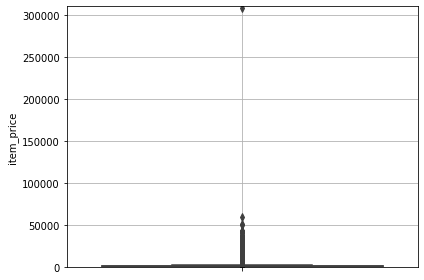

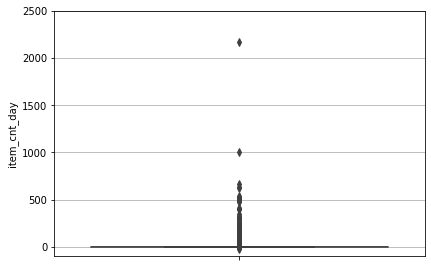

In [56]:
# item_priceとitem_cnt_dayの箱ひげ図表示
plt.ylim(-100, 310000)
sns.boxplot(y='item_price', data=train)
plt.grid()
plt.tight_layout()
plt.show()
plt.ylim(-100, 2500)
plt.grid()
plt.tight_layout()
sns.boxplot(y='item_cnt_day', data=train)

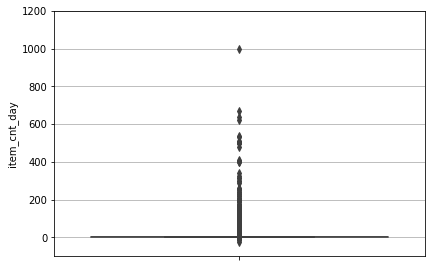

In [57]:
# item_cnt_dayを上限1200で表示
plt.ylim(-100, 1200)
plt.grid()
plt.tight_layout()
sns.boxplot(y='item_cnt_day', data=train)

#### item_priceとitem_cnt_dayの外れ値を除外します。

- item_price < 100000
- item_cnt_day < 1200

In [58]:
# 外れ値の除外
print('before ', train.shape)
train = train[train['item_price'] < 100000]
train = train[train['item_cnt_day'] < 1200]
print('after ', train.shape)

before  (2935849, 11)
after  (2935847, 11)


#### item_priceの-1の値のデータを確認します。

In [59]:
# item_priceが-1のデータ数
print(train[train['item_price'] == -1]['item_price'].value_counts())
# item_priceの-1の値を持つデータの確認
train[train['item_price'] == -1]

-1.0    1
Name: item_price, dtype: int64


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_month,item_category_id,type_code,subtype_code,city_code
484683,15.05.2013,5,32,2973,-1.0,1.0,5.0,19,5,10,13


item_priceの-1の値と共通するほかデータ内容がないかを確認します

In [60]:
# item_id 2973のときのitem_price出現個数の確認
train.loc[train['item_id'] == 2973, 'item_price'].value_counts()

 2499.000000    444
 1249.500000    124
 1249.000000     96
 1901.000000     28
 1250.000000     12
 2498.500000     12
 1562.030029     10
 1275.010010      9
 2498.750000      6
 1999.000000      3
 1329.290039      3
 1275.270020      3
 1837.849976      3
 1487.609985      3
 2498.899902      2
 1453.000000      2
 2248.800049      1
 1832.369995      1
 1049.000000      1
 1998.400024      1
 2249.000000      1
 1454.119995      1
 1248.699951      1
 1523.910034      1
 1248.900024      1
 2373.949951      1
 1249.099976      1
 1388.400024      1
 2498.399902      1
 2498.699951      1
 2498.833252      1
 2498.875000      1
 2498.916748      1
 1297.579956      1
 2427.571533      1
-1.000000         1
Name: item_price, dtype: int64

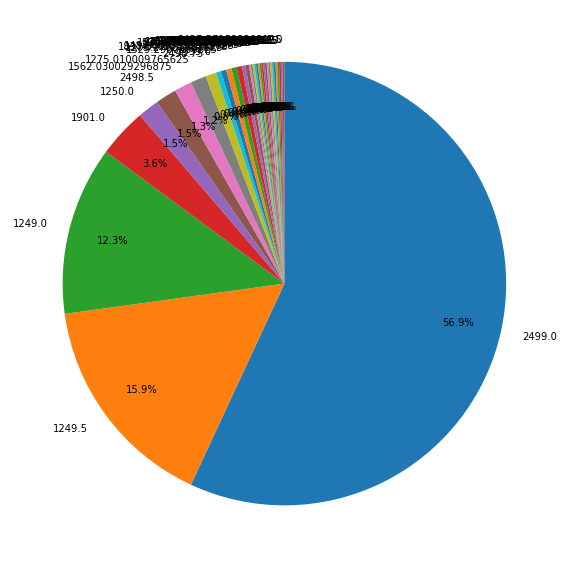

In [61]:
# 円グラフで可視化
plt.figure(figsize=(8, 8))
plt.pie(
    train.loc[train['item_id'] == 2973, 'item_price'].value_counts(),    # データの出現頻度
    labels=train.loc[train['item_id'] == 2973, 'item_price'].value_counts().index,    # ラベル名の指定
    counterclock=False,    # データを時計回りに入れる
    startangle=90,          # データの開始位置 90の場合は円の上から開始
    autopct='%1.1f%%',      # グラフ内に構成割合のラベルを小数点1桁まで表示
    pctdistance=0.8         # ラベルの表示位置
)
plt.tight_layout()
plt.show()

なんとなく2499、1249.5、1249のどれかに変換するのがいい気がするけど感覚の世界なので保留します。<br>item_idが2973でshop_idが32のときのitem_priceを確認してみます。

In [62]:
# item_id 2973のときの訓練データを抽出
item_id_2973 = train[train['item_id'] == 2973]
# item_id_2973の中で、shop_id 32のデータを抽出し、出現個数を確認
item_id_2973.loc[item_id_2973['shop_id']==32, 'item_price'].value_counts()

 2499.0    10
 1249.5     1
-1.0        1
 1249.0     1
Name: item_price, dtype: int64

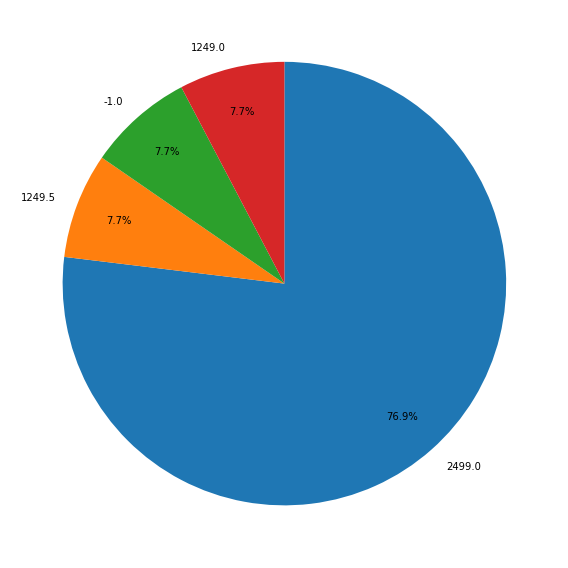

In [63]:
# 円グラフで可視化
plt.figure(figsize=(8, 8))
plt.pie(
    item_id_2973.loc[item_id_2973['shop_id']==32, 'item_price'].value_counts(),    # データの出現頻度
    labels=item_id_2973.loc[item_id_2973['shop_id']==32, 'item_price'].value_counts().index,    # ラベル名の指定
    counterclock=False,    # データを時計回りに入れる
    startangle=90,          # データの開始位置 90の場合は円の上から開始
    autopct='%1.1f%%',      # グラフ内に構成割合のラベルを小数点1桁まで表示
    pctdistance=0.8         # ラベルの表示位置
)
plt.tight_layout()
plt.show()

この結果から訓練データのitem_priceが-1のデータは2499.0で置き換えます。

In [64]:
# item_priceの-1の値を2499.0に置き換える
train[train['item_price'] == -1] = 2499

In [65]:
# 置き換えが完了したかの確認
train[train['item_price'] == -1]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_month,item_category_id,type_code,subtype_code,city_code


In [66]:
train.dtypes

date                 object
date_block_num         int8
shop_id                int8
item_id               int16
item_price          float32
item_cnt_day        float16
item_cnt_month      float16
item_category_id       int8
type_code             int64
subtype_code          int64
city_code             int64
dtype: object

In [67]:
# object型の確認
train.select_dtypes(include=object).head()

,date
0,02.01.2013
1,03.01.2013
2,05.01.2013
3,06.01.2013
4,15.01.2013


In [68]:
# object型の確認
test.select_dtypes(include=object).head()

""
0
1
2
3
4


## モデルのベースライン

全てのデータを結合したのでLightGBMでベースラインになるモデルを作成します。

In [69]:
# object型の`date`を削除
train.drop('date', axis=1 ,inplace=True)

In [70]:
# 説明変数item_priceがtestより多い
train.shape

(2935847, 10)

In [71]:
test.shape

(214200, 8)

### 訓練データのitem_priceをテストデータにマージ

テストデータには`item_price`がないので訓練データから作成します

- 'shop_id','item_id'でグループ化し、'item_price'の平均を取得
- テストデータの'shop_id', 'item_id'にマージ
<!-- - 欠損値があれば'item_price'の中央値で補完 -->

In [72]:
train['item_price']

0           999.000000
1           899.000000
2           899.000000
3          1709.050049
4          1099.000000
              ...     
2935844     299.000000
2935845     299.000000
2935846     349.000000
2935847     299.000000
2935848     299.000000
Name: item_price, Length: 2935847, dtype: float32

In [73]:
# trainデータにて、'shop_id','item_id'でGROUP化したDataFrameGroupByオブジェクトに対して、'item_price'の平均
group_item_price = train.groupby(['shop_id','item_id']).agg({'item_price': ['mean']})
# 列名の更新
group_item_price.columns = ['item_price']
# DataFrameGroupBy -> DataFrame に変換
group_item_price.reset_index(inplace=True)
group_item_price.head()

,shop_id,item_id,item_price
0,-61,2499,2499.00000
1,2,27,1498.50000
2,2,30,274.00000
3,2,31,626.05249
4,2,32,146.27272


In [74]:
print('before ', test.shape)
# 'shop_id', 'item_id'のデータを結合
test = pd.merge(test, group_item_price, on=['shop_id', 'item_id'], how='left')
print('after ', test.shape)
test.head()

before  (214200, 8)
after  (214200, 9)


,ID,shop_id,item_id,item_category_id,type_code,subtype_code,city_code,date_block_num,item_price
0,0,5,5037,19,5,10,3,34,1633.692261
1,1,5,5320,55,13,2,3,34,NaN
2,2,5,5233,19,5,10,3,34,865.666687
3,3,5,5232,23,5,16,3,34,599.000000
4,4,5,5268,20,5,11,3,34,NaN


In [75]:
# item_priceの欠損値を中央値で補完
test['item_price'] = test['item_price'].fillna(test['item_price'].median())

In [76]:
# 説明変数item_priceがtestより多い
train.shape

(2935847, 10)

In [77]:
test.shape

(214200, 9)

## LightGBM

事前準備として以下の内容が必要です。

1. 学習用・検証用にデータセットを分割する
2. カテゴリー変数をリスト形式で宣言する（今回特になし）

In [78]:
# 目的変数と説明変数に分割
y_train = train['item_cnt_month']    # 目的変数
X_train = train.drop('item_cnt_month', axis=1)    # 訓練データの説明変数
X_test = test

## 学習用データを学習用・検証用に分割する

In [79]:
from sklearn.model_selection import train_test_split

# train:valid = 7:3
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,             # 対象データ1
    y_train,             # 対象データ2
    test_size=0.3,       # 検証用データを3に指定
#     stratify=y_train,    # 訓練データで層化抽出
    random_state=42
)

## LightGBMで学習の実施

In [80]:
# LightGBMで学習の実施
import lightgbm as lgb

# カテゴリー変数をリスト形式で宣言(A-Z順で宣言する)
categorical_features = ['city_code', 'type_code', 'subtype_code']

# データセットの初期化
lgb_train = lgb.Dataset(
    X_train,
    y_train,
    categorical_feature=categorical_features
)

lgb_valid = lgb.Dataset(
    X_valid,
    y_valid,
    reference=lgb_train,    # 検証用データで参照として使用する訓練データの指定
    categorical_feature=categorical_features
)

# パラメータの設定
params = {
        'objective': 'regression',    # 回帰問題
        'metric': 'rmse',      # RMSE (平均二乗誤差平方根) の最小化を目指す
        'learning_rate': 0.1, # 学習率
        'max_depth': -1, # 木の数 (負の値で無制限)
        'num_leaves': 9, # 枝葉の数
        'drop_rate': 0.15,
        'verbose': 0
    }

lgb_model = lgb.train(
    params,    # パラメータ
    lgb_train,    # 学習用データ
    valid_sets=[lgb_train, lgb_valid],    # 訓練中に評価されるデータ
    verbose_eval=10,    # 検証データは10個
    num_boost_round=1000,    # 学習の実行回数の最大値
    early_stopping_rounds=100    # 連続25回学習で検証データの性能が改善しない場合学習を打ち切る
)

Training until validation scores don't improve for 100 rounds
[10]	training's rmse: 6.79247	valid_1's rmse: 6.00378
[20]	training's rmse: 6.76545	valid_1's rmse: 5.99264
[30]	training's rmse: 6.75313	valid_1's rmse: 5.99213
[40]	training's rmse: 6.74346	valid_1's rmse: 5.99448
[50]	training's rmse: 6.73681	valid_1's rmse: 5.99814
[60]	training's rmse: 6.73013	valid_1's rmse: 6.0005
[70]	training's rmse: 6.72528	valid_1's rmse: 6.00276
[80]	training's rmse: 6.72108	valid_1's rmse: 6.00473
[90]	training's rmse: 6.71584	valid_1's rmse: 6.00671
[100]	training's rmse: 6.71202	valid_1's rmse: 6.00836
[110]	training's rmse: 6.70665	valid_1's rmse: 6.01007
[120]	training's rmse: 6.70364	valid_1's rmse: 6.01247
Early stopping, best iteration is:
[26]	training's rmse: 6.75722	valid_1's rmse: 5.99163


In [81]:
# 特徴量重要度の算出 (データフレームで取得)
cols = list(X_train.columns) # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(lgb_model.feature_importance()) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

,feature,importance
0,date_block_num,0.346154
4,item_cnt_day,0.163462
8,city_code,0.153846
3,item_price,0.120192
7,subtype_code,0.110577
1,shop_id,0.067308
2,item_id,0.033654
5,item_category_id,0.004808
6,type_code,0.000000


Text(0, 0.5, 'Feature')

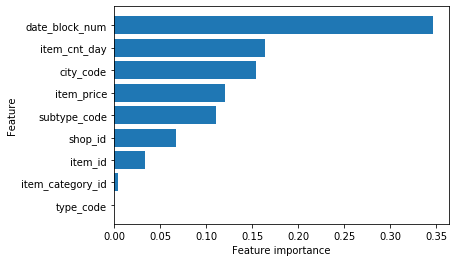

In [82]:
# 特徴量重要度の可視化
n_features = len(df_importance) # 特徴量数(説明変数の個数) 
df_plot = df_importance.sort_values('importance') # df_importanceをプロット用に特徴量重要度を昇順ソート 
f_imoprtance_plot = df_plot['importance'].values # 特徴量重要度の取得 
plt.barh(range(n_features), f_imoprtance_plot, align='center') 
cols_plot = df_plot['feature'].values # 特徴量の取得 
plt.yticks(np.arange(n_features), cols_plot)  # x軸,y軸の値の設定
plt.xlabel('Feature importance') # x軸のタイトル
plt.ylabel('Feature') # y軸のタイトル

In [83]:
# 推論                 
lgb_y_pred = lgb_model.predict(
    X_test,    # 予測を行うデータ
    num_iteration=lgb_model.best_iteration, # 繰り返しのインデックス Noneの場合、best_iterationが存在するとダンプされます。それ以外の場合、すべての繰り返しがダンプされます。 <= 0の場合、すべての繰り返しがダンプされます。
)
# 結果の表示
lgb_y_pred[:10]

array([2.11275127, 2.11275127, 2.11275127, 2.11275127, 2.11275127,
       2.26968993, 2.26968993, 2.26968993, 2.22878015, 2.20818872])

In [84]:
# 予測データをcsvに変換
sub = pd.read_csv(PATH+'/sample_submission.csv')    # サンプルの予測データ
sub['item_cnt_month'] = lgb_y_pred

sub.to_csv(PATH+'/submit_lightgbm.csv', index=False)
sub.head()

,ID,item_cnt_month
0,0,2.112751
1,1,2.112751
2,2,2.112751
3,3,2.112751
4,4,2.112751


結果=`1.23409`

## 推論に寄与しなかった特徴量を削除してLightGBMを実行

In [85]:
# object型の`date`を削除
train.drop(['item_category_id', 'type_code'], axis=1 ,inplace=True)
# object型の`date`を削除
test.drop(['item_category_id', 'type_code'], axis=1 ,inplace=True)

In [86]:
# 目的変数と説明変数に分割
y_train = train['item_cnt_month']    # 目的変数
X_train = train.drop('item_cnt_month', axis=1)    # 訓練データの説明変数
X_test = test

In [87]:
# train:valid = 7:3
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,             # 対象データ1
    y_train,             # 対象データ2
    test_size=0.3,       # 検証用データを3に指定
#     stratify=y_train,    # 訓練データで層化抽出
    random_state=42
)

## LightGBMで学習の実施

In [88]:
# カテゴリー変数をリスト形式で宣言(A-Z順で宣言する)
categorical_features = ['city_code', 'subtype_code']

# データセットの初期化
lgb_train = lgb.Dataset(
    X_train,
    y_train,
    categorical_feature=categorical_features
)

lgb_valid = lgb.Dataset(
    X_valid,
    y_valid,
    reference=lgb_train,    # 検証用データで参照として使用する訓練データの指定
    categorical_feature=categorical_features
)

# パラメータの設定
params = {
        'objective': 'regression',    # 回帰問題
        'metric': 'rmse',      # RMSE (平均二乗誤差平方根) の最小化を目指す
    }

lgb_model = lgb.train(
    params,    # パラメータ
    lgb_train,    # 学習用データ
    valid_sets=[lgb_train, lgb_valid],    # 訓練中に評価されるデータ
    verbose_eval=10,    # 検証データは10個
    num_boost_round=1000,    # 学習の実行回数の最大値
    early_stopping_rounds=25    # 連続25回学習で検証データの性能が改善しない場合学習を打ち切る
)

Training until validation scores don't improve for 25 rounds
[10]	training's rmse: 6.75436	valid_1's rmse: 5.99981
[20]	training's rmse: 6.70464	valid_1's rmse: 5.99207
[30]	training's rmse: 6.68266	valid_1's rmse: 5.99305
[40]	training's rmse: 6.66415	valid_1's rmse: 5.99854
Early stopping, best iteration is:
[23]	training's rmse: 6.69772	valid_1's rmse: 5.99176


In [89]:
# 特徴量重要度の算出 (データフレームで取得)
cols = list(X_train.columns) # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(lgb_model.feature_importance()) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

,feature,importance
0,date_block_num,0.226087
2,item_id,0.159420
6,city_code,0.144928
3,item_price,0.142029
5,subtype_code,0.123188
1,shop_id,0.120290
4,item_cnt_day,0.084058


Text(0, 0.5, 'Feature')

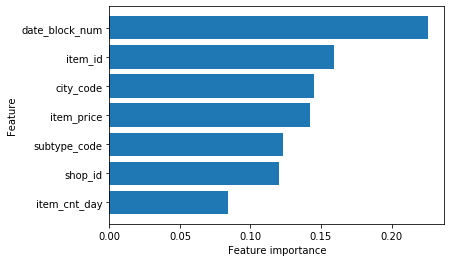

In [90]:
# 特徴量重要度の可視化
n_features = len(df_importance) # 特徴量数(説明変数の個数) 
df_plot = df_importance.sort_values('importance') # df_importanceをプロット用に特徴量重要度を昇順ソート 
f_imoprtance_plot = df_plot['importance'].values # 特徴量重要度の取得 
plt.barh(range(n_features), f_imoprtance_plot, align='center') 
cols_plot = df_plot['feature'].values # 特徴量の取得 
plt.yticks(np.arange(n_features), cols_plot)  # x軸,y軸の値の設定
plt.xlabel('Feature importance') # x軸のタイトル
plt.ylabel('Feature') # y軸のタイトル

In [91]:
## 推論                 
lgb_y_pred2 = lgb_model.predict(
    X_test,    # 予測を行うデータ
    num_iteration=lgb_model.best_iteration, # 繰り返しのインデックス Noneの場合、best_iterationが存在するとダンプされます。それ以外の場合、すべての繰り返しがダンプされます。 <= 0の場合、すべての繰り返しがダンプされます。
)
# 結果の表示
lgb_y_pred2[:10]

array([2.0554154 , 2.0554154 , 2.0554154 , 2.0554154 , 2.0554154 ,
       2.22360713, 2.21943354, 2.21943354, 2.17059552, 2.10711936])

In [92]:
# 予測データをcsvに変換
sub2 = pd.read_csv(PATH+'/sample_submission.csv')    # サンプルの予測データ
sub2['item_cnt_month'] = lgb_y_pred

sub2.to_csv(PATH+'/submit_lightgbm_drop_futer.csv', index=False)
sub2.head()

,ID,item_cnt_month
0,0,2.112751
1,1,2.112751
2,2,2.112751
3,3,2.112751
4,4,2.112751


結果=`1.23409`

`shop_id`や`item_id`をカテゴリー変数として学習させていないので、この辺りを変えるだけでも結果は変わるかも

## LightGBMで学習の実施

In [93]:
# カテゴリー変数をリスト形式で宣言(A-Z順で宣言する)
categorical_features = ['city_code', 'item_id','subtype_code', 'shop_id']

# データセットの初期化
lgb_train = lgb.Dataset(
    X_train,
    y_train,
    categorical_feature=categorical_features
)

lgb_valid = lgb.Dataset(
    X_valid,
    y_valid,
    reference=lgb_train,    # 検証用データで参照として使用する訓練データの指定
    categorical_feature=categorical_features
)

# パラメータの設定
params = {
        'objective': 'regression',    # 回帰問題
        'metric': 'rmse',      # RMSE (平均二乗誤差平方根) の最小化を目指す
    }

lgb_model = lgb.train(
    params,    # パラメータ
    lgb_train,    # 学習用データ
    valid_sets=[lgb_train, lgb_valid],    # 訓練中に評価されるデータ
    verbose_eval=10,    # 検証データは10個
    num_boost_round=1000,    # 学習の実行回数の最大値
    early_stopping_rounds=25    # 連続25回学習で検証データの性能が改善しない場合学習を打ち切る
)

Training until validation scores don't improve for 25 rounds
[10]	training's rmse: 6.68423	valid_1's rmse: 6.02726
[20]	training's rmse: 6.58681	valid_1's rmse: 6.03769
[30]	training's rmse: 6.50472	valid_1's rmse: 6.0487
Early stopping, best iteration is:
[10]	training's rmse: 6.68423	valid_1's rmse: 6.02726


In [94]:
# 特徴量重要度の算出 (データフレームで取得)
cols = list(X_train.columns) # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(lgb_model.feature_importance()) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

,feature,importance
0,date_block_num,0.396667
2,item_id,0.220000
1,shop_id,0.173333
3,item_price,0.173333
4,item_cnt_day,0.033333
6,city_code,0.003333
5,subtype_code,0.000000


Text(0, 0.5, 'Feature')

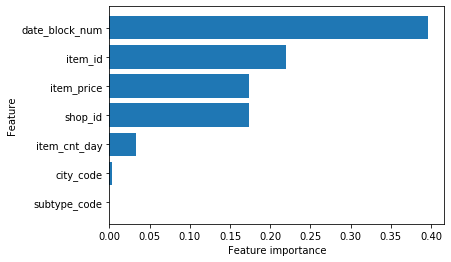

In [95]:
# 特徴量重要度の可視化
n_features = len(df_importance) # 特徴量数(説明変数の個数) 
df_plot = df_importance.sort_values('importance') # df_importanceをプロット用に特徴量重要度を昇順ソート 
f_imoprtance_plot = df_plot['importance'].values # 特徴量重要度の取得 
plt.barh(range(n_features), f_imoprtance_plot, align='center') 
cols_plot = df_plot['feature'].values # 特徴量の取得 
plt.yticks(np.arange(n_features), cols_plot)  # x軸,y軸の値の設定
plt.xlabel('Feature importance') # x軸のタイトル
plt.ylabel('Feature') # y軸のタイトル

In [96]:
## 推論                 
lgb_y_pred3 = lgb_model.predict(
    X_test,    # 予測を行うデータ
    num_iteration=lgb_model.best_iteration, # 繰り返しのインデックス Noneの場合、best_iterationが存在するとダンプされます。それ以外の場合、すべての繰り返しがダンプされます。 <= 0の場合、すべての繰り返しがダンプされます。
)
# 結果の表示
lgb_y_pred3[:10]

array([1.88436711, 1.88436711, 1.88436711, 1.88436711, 1.88436711,
       1.88436711, 1.88436711, 1.88436711, 1.88436711, 1.88436711])

In [97]:
# 予測データをcsvに変換
sub3 = pd.read_csv(PATH+'/sample_submission.csv')    # サンプルの予測データ
sub3['item_cnt_month'] = lgb_y_pred

sub3.to_csv(PATH+'/submit_lightgbm_drop_cate.csv', index=False)
sub3.head()

,ID,item_cnt_month
0,0,2.112751
1,1,2.112751
2,2,2.112751
3,3,2.112751
4,4,2.112751


結果=`1.23409`